In [2]:
import os
import mlflow
import numpy as np
import pandas as pd

from math import sqrt
from joblib import delayed
from joblib import Parallel

from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import pyplot
import matplotlib.dates as mdates

from pathlib import Path
from functools import reduce
from datetime import datetime

from prophet import Prophet

import random
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from regressors import stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import statsmodels.api as sm


Importing plotly failed. Interactive plots will not work.


## Load data

In [3]:
df = pd.read_csv('./../../../data/error_dfs/error_2018_2019_VAR.csv', converters={'ags2': str, 'ags5': str} )

In [4]:
# fix ags5 missing 0 
df['ags5'] = np.where(df.ags5.str.len() ==4, '0' + df['ags5'], df['ags5'])

In [5]:
# add 'ags2','bundesland','kreis'
df2 = pd.read_csv('./../../../data/corona_data_sets/oeffentliche_finanzen.csv', converters={'ags2': str, 'ags5': str} )
df = pd.merge(df, df2[['ags2','ags5','bundesland','kreis']])
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df['error'] = df['ground_truth'] - df['pred']
df

,date,ground_truth,pred,ags5,ags2,bundesland,kreis,error
0,2018-01-01,9.3,9.100280,01001,01,Schleswig-Holstein,"Flensburg, Stadt",0.199720
1,2018-02-01,9.2,9.081553,01001,01,Schleswig-Holstein,"Flensburg, Stadt",0.118447
2,2018-03-01,9.1,8.925309,01001,01,Schleswig-Holstein,"Flensburg, Stadt",0.174691
3,2018-04-01,8.8,8.987270,01001,01,Schleswig-Holstein,"Flensburg, Stadt",-0.187270
4,2018-05-01,8.3,8.770163,01001,01,Schleswig-Holstein,"Flensburg, Stadt",-0.470163
...,...,...,...,...,...,...,...,...
9619,2019-08-01,7.0,6.928729,16077,16,Thüringen,Altenburger Land,0.071271
9620,2019-09-01,6.5,6.595042,16077,16,Thüringen,Altenburger Land,-0.095042
9621,2019-10-01,6.5,6.526319,16077,16,Thüringen,Altenburger Land,-0.026319
9622,2019-11-01,6.3,6.483260,16077,16,Thüringen,Altenburger Land,-0.183260


In [6]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

## Plot each variable

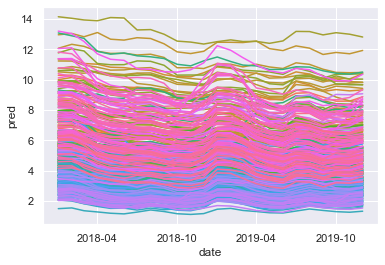

In [7]:
g = sns.lineplot(data=df, x="date", y="pred",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

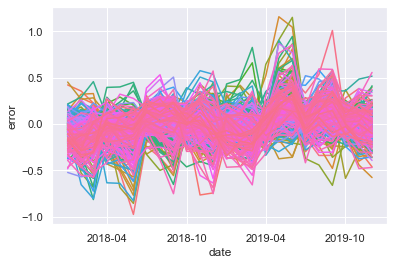

In [8]:
g = sns.lineplot(data=df, x="date", y="error",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

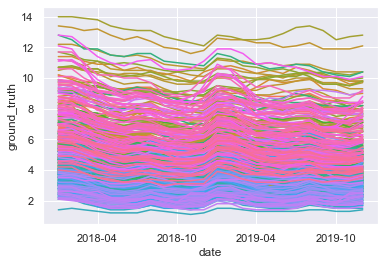

In [9]:
g = sns.lineplot(data=df, x="date", y="ground_truth",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

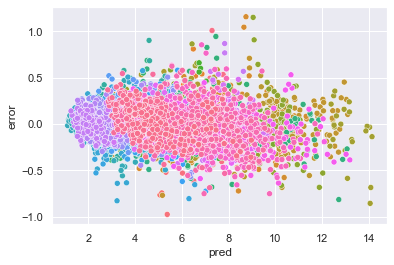

In [10]:
g = sns.scatterplot(data=df, x="pred", y="error",  hue="ags5")
g.legend_.remove()

## Plot sample to compare prediction to ground truth

In [11]:
df_long = df.melt(id_vars=['date','ags5','ags2','bundesland','kreis'], var_name='y_type', value_name='vals')

In [12]:
df_long = df_long[df_long['y_type'].isin(['ground_truth','pred'])]

In [13]:
sample_args = random.sample(list(set(df_long['ags5'])), 30)
df_sample = df_long[df_long['ags5'].isin(sample_args)]

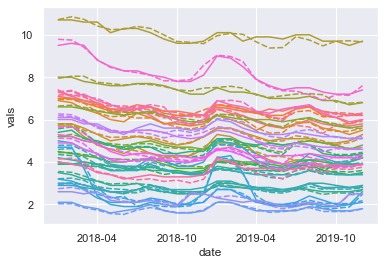

In [14]:
g = sns.lineplot(data=df_sample, x="date", y="vals",  hue="ags5", style="y_type")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

## Look into mean errors

In [15]:
df_mean_error = df.groupby(['ags5','ags2','bundesland','kreis']).mean()
df_mean_error              

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
01001,01,Schleswig-Holstein,"Flensburg, Stadt",8.137500,8.067004,0.070496
01002,01,Schleswig-Holstein,"Kiel, Landeshauptstadt",7.883333,7.943206,-0.059873
01003,01,Schleswig-Holstein,"Lübeck, Hansestadt",7.525000,7.506519,0.018481
01004,01,Schleswig-Holstein,"Neumünster, Stadt",8.125000,8.089037,0.035963
01051,01,Schleswig-Holstein,Dithmarschen,5.887500,5.977891,-0.090391
...,...,...,...,...,...,...
16073,16,Thüringen,Saalfeld-Rudolstadt,5.375000,5.351936,0.023064
16074,16,Thüringen,Saale-Holzland-Kreis,4.329167,4.329224,-0.000057
16075,16,Thüringen,Saale-Orla-Kreis,4.733333,4.757153,-0.023820


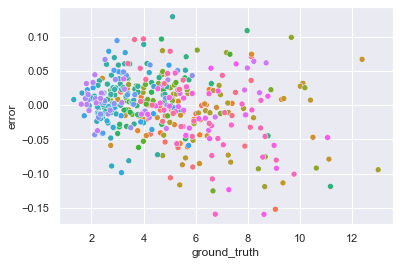

In [16]:
g = sns.scatterplot(data=df_mean_error, x="ground_truth", y="error",  hue="ags5")
g.legend_.remove()

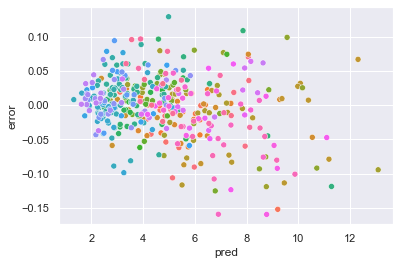

In [17]:
g = sns.scatterplot(data=df_mean_error, x="pred", y="error",  hue="ags5")
g.legend_.remove()

In [18]:
df_mean_error.sort_values(by = ['error'], ascending=False)

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
08222,08,Baden-Württemberg,Mannheim,5.112500,4.983475,0.129025
07314,07,Rheinland-Pfalz,Stadt Ludwigshafen a. Rh.,7.970833,7.862117,0.108716
05914,05,Nordrhein-Westfalen,Hagen,9.666667,9.567778,0.098889
16066,16,Thüringen,Schmalkalden-Meiningen,3.995833,3.899234,0.096600
07211,07,Rheinland-Pfalz,Stadt Trier,4.687500,4.591109,0.096391
...,...,...,...,...,...,...
13003,13,Mecklenburg-Vorpommern,"Rostock, Hansestadt",7.270833,7.394368,-0.123535
06414,06,Hessen,Landeshauptstadt Wiesbaden,6.662500,6.787757,-0.125257
03102,03,Niedersachsen,Salzgitter,9.054167,9.206296,-0.152129


<AxesSubplot:xlabel='error', ylabel='Density'>

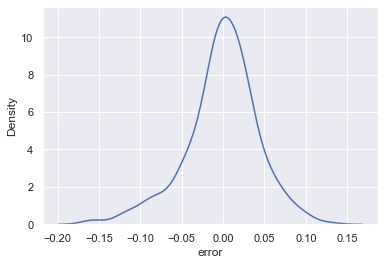

In [19]:
sns.kdeplot(data=df_mean_error, x="error", common_norm=False)

## Look into errors

In [20]:
df.sort_values(by = ['error'], ascending=False)

,date,ground_truth,pred,ags5,ags2,bundesland,kreis,error
1072,2019-05-01,9.9,8.742431,03401,03,Niedersachsen,Delmenhorst,1.157569
2561,2019-06-01,10.2,9.049288,05914,05,Nordrhein-Westfalen,Hagen,1.150712
1073,2019-06-01,9.7,8.654940,03401,03,Niedersachsen,Delmenhorst,1.045060
20,2019-09-01,8.3,7.290813,01001,01,Schleswig-Holstein,"Flensburg, Stadt",1.009187
3881,2019-06-01,8.4,7.455139,07314,07,Rheinland-Pfalz,Stadt Ludwigshafen a. Rh.,0.944861
...,...,...,...,...,...,...,...,...
6218,2018-03-01,5.5,6.303624,09363,09,Freistaat Bayern,Weiden i.d.OPf.,-0.803624
3938,2018-03-01,11.9,12.713329,07317,07,Rheinland-Pfalz,Stadt Pirmasens,-0.813329
6077,2018-06-01,2.4,3.226777,09276,09,Freistaat Bayern,Regen,-0.826777
2165,2018-06-01,13.2,14.054424,05513,05,Nordrhein-Westfalen,Gelsenkirchen,-0.854424


In [21]:
df['diff_ground_truth'] = df.groupby('ags5')['ground_truth'].diff(1) 
df['diff_ground_truth_abs'] = df['diff_ground_truth'].abs()

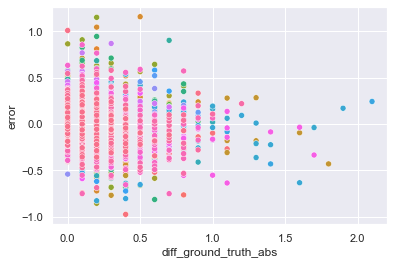

In [22]:
g = sns.scatterplot(data=df, x="diff_ground_truth_abs", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='error', ylabel='Density'>

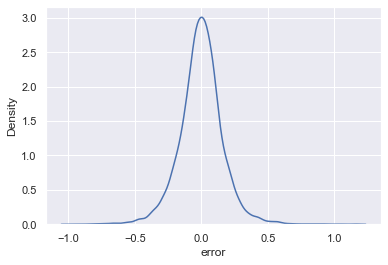

In [23]:
sns.kdeplot(data=df, x="error", common_norm=False)

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='error', ylabel='Density'>

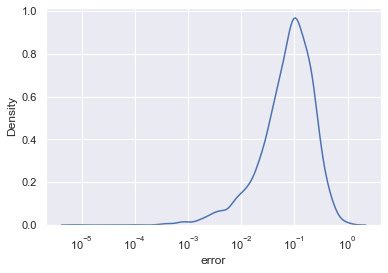

In [24]:
sns.kdeplot(data=df, x="error", common_norm=False,log_scale=True)

# Load structural data

In [25]:
df_structural = pd.read_csv('./../../../data/final_dfs/for_modeling/df_final_stationery.csv', converters={'ags2': str, 'ags5': str} )

df_structural["urban_/_rural"] = np.where(df_structural["urban_/_rural"]==1, 'urban', 'rural')
df_structural['eligible_area'] = np.where(df_structural['eligible_area']==1, 'eligible_area', 'not_eligible_area')
df_structural['east_west'] = np.where(df_structural['east_west']==1, 'west', 'east')
df_structural = df_structural.rename(columns={'urban_/_rural': 'urban_rural'})
df_structural

,cluster,kreis,ags5,ags2,supermarkets_population,supermarkets_average_distance,public_transport_availability,average_distance_bus_stop,average_distance_train_station,average_distance_public_transport,...,room_type_location,district_settlement_structure,type_of_settlement_structure,urban_rural,metropolitan_region,metropolitan_area,east_west,border_proximity,support_area_status,eligible_area
0,0,"Flensburg, Stadt",01001,01,92,500,35,240,2901,240,...,2,4,3,rural,99,99,west,1,C,eligible_area
1,2,"Kiel, Landeshauptstadt",01002,01,92,460,37,268,2037,265,...,2,1,2,urban,99,99,west,0,C/D,eligible_area
2,2,"Lübeck, Hansestadt",01003,01,90,532,37,297,1927,294,...,1,1,2,urban,5,99,west,0,C/D,eligible_area
3,0,"Neumünster, Stadt",01004,01,85,588,37,316,1648,313,...,2,3,2,rural,5,99,west,0,D,eligible_area
4,0,Dithmarschen,01051,01,51,1864,35,448,3517,443,...,4,4,3,rural,5,99,west,0,C,eligible_area
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0,Saalfeld-Rudolstadt,16073,16,62,1423,37,341,2492,322,...,3,4,2,rural,99,99,east,0,C*,eligible_area
397,0,Saale-Holzland-Kreis,16074,16,54,1677,38,343,3419,340,...,3,3,2,rural,99,99,east,0,C*,eligible_area
398,0,Saale-Orla-Kreis,16075,16,54,1686,35,449,3172,444,...,3,4,2,rural,99,99,east,2,C*,eligible_area
399,0,Greiz,16076,16,55,1654,38,608,2779,563,...,3,2,2,urban,99,99,east,0,C*,eligible_area


### Merge to df with mean errors

In [26]:
df_mixed = pd.merge(df_mean_error, df_structural, on = ['ags5','ags2'])
df_mixed['ags2'] = df_mixed['ags2'].astype('category')
list(df_mixed.columns)

['ags5',
 'ags2',
 'ground_truth',
 'pred',
 'error',
 'cluster',
 'kreis',
 'supermarkets_population',
 'supermarkets_average_distance',
 'public_transport_availability',
 'average_distance_bus_stop',
 'average_distance_train_station',
 'average_distance_public_transport',
 'Unnamed:_0',
 'number_of_students',
 'number_of_hospitals',
 'number_of_hospital_beds',
 'number_of_hospital_beds_adj',
 'hospital_patiants',
 'households_of_1_person',
 'households_of_2_person',
 'households_of_3_person',
 'households_of_4_person',
 'households_of_5_person_or_more',
 'household_with_kids',
 'household_with_kids_under_3',
 'household_with_kids_over_3_under_6',
 'household_with_kids_over_6_under_10',
 'household_with_kids_over_10_under_15',
 'household_with_kids_over_15_under_18',
 'household_with_double_income_no_kids',
 'car_density',
 'no_of_paths_per_person_and_day',
 'kilometers_per_person_and_day',
 '_percentage_out_of_home',
 'share_of_journeys_on_foot',
 'share_of_journeys_on_bike',
 'propo

### Compare error in two_groups

In [27]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    p = sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    p.set_title('Residuals')
    plt.savefig(f'{column_name}_resid.png')
    plt.show()
    df[column_name] = df[column_name].astype(str)
    one, two = list(set(df[column_name]))
    df_one = df[df[column_name]==one]
    df_two = df[df[column_name]==two]
    return ttest_ind(df_one['error'], df_two['error'], equal_var=False)

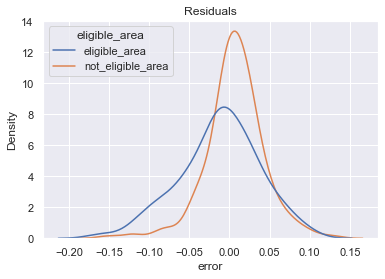

Ttest_indResult(statistic=-4.2396907573530065, pvalue=2.9982314674992313e-05)

In [28]:
compare_error_in_two_groups(df_mixed, 'eligible_area')

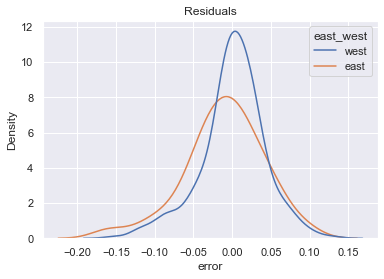

Ttest_indResult(statistic=1.773516959523856, pvalue=0.0791581867124055)

In [29]:
compare_error_in_two_groups(df_mixed, 'east_west')

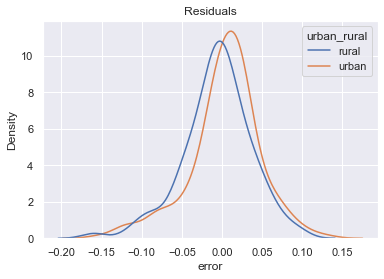

Ttest_indResult(statistic=-2.172618864774237, pvalue=0.030399151101918785)

In [30]:
compare_error_in_two_groups(df_mixed, 'urban_rural')

### Compare compare error in multiple groups

In [31]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    plt.show()
    mod = ols(f'error ~ {column_name}',
                data=df).fit()
                
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print(aov_table)

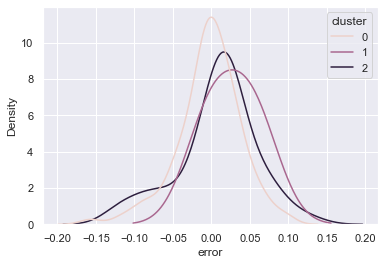

            sum_sq     df         F    PR(>F)
cluster   0.005946    1.0  3.112598  0.078454
Residual  0.762167  399.0       NaN       NaN


In [32]:
compare_error_in_two_groups(df_mixed, "cluster")

In [33]:
#compare_error_in_two_groups(df_mixed, "bundesland")

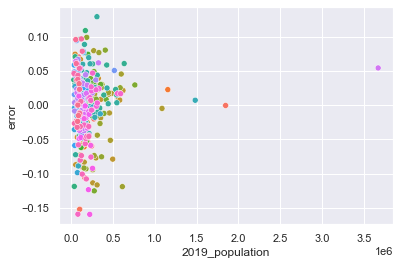

In [34]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

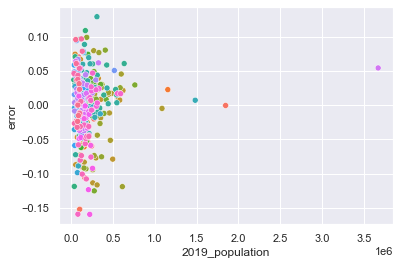

In [35]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

### Linear Regression

In [36]:
df_mixed.set_index('ags5', drop=True, inplace=True)

In [43]:
df_mixed['east_west'] = df_mixed['east_west'].astype(str)
df_mixed['eligible_area'] = df_mixed['eligible_area'].astype(str)
df_mixed['cluster'] = df_mixed['cluster'].astype(str)
df_mixed['urban_rural'] = df_mixed['urban_rural'].astype(str)

X = df_mixed.drop(['kreis','pred','error','ground_truth','Unnamed:_0'], axis=1)
Y = df_mixed['error']

X = pd.get_dummies(data=X, drop_first=True)

In [37]:
df_mixed['east_west']

ags5
01001    west
01002    west
01003    west
01004    west
01051    west
         ... 
16073    east
16074    east
16075    east
16076    east
16077    east
Name: east_west, Length: 401, dtype: object

In [44]:
regr = LinearRegression()
regr.fit(X, Y, sample_weight=None)

LinearRegression()

In [60]:
stats.summary(regr, X, Y, X.columns)

Residuals:
    Min      1Q  Median    3Q    Max
-0.0776 -0.0172  0.0008 0.015 0.0663


Coefficients:
                                                   Estimate                  Std. Error          t value   p value
_intercept                                         3.296182  564.410488+013422.3357890j   0.0000-0.0002j  0.999804
supermarkets_population                            0.000458  0.0035500000+0.0000260000j   0.1290-0.0010j  0.897381
supermarkets_average_distance                     -0.000013  0.0022410000+0.0000070000j  -0.0059+0.0000j  0.995271
public_transport_availability                      0.001323  0.0014200000+0.0000060000j   0.9312-0.0036j  0.352325
average_distance_bus_stop                         -0.000031  0.0000160000+0.0000030000j  -1.8733+0.2938j  0.058658
average_distance_train_station                     0.000005  0.0000120000+0.0000040000j   0.3948-0.1258j  0.678789
average_distance_public_transport                  0.000057  0.0000230000+0.0000320000j   0.86

In [39]:
model = sm.OLS(Y,X)
results = model.fit()

def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals
                                })

    #Reordering...
    results_df = results_df[["pvals"]]
    return results_df

res = results_summary_to_dataframe(results)
res.reset_index(inplace=True)
res = res.rename(columns={'index': 'feature'})

res

NameError: name 'Y' is not defined

In [90]:
res = res.sort_values(by=['pvals'], ascending=True)
res

,feature,pvals
49,2018_population_25_to_30,0.001417
39,2019_population,0.002097
167,metropolitan_region,0.002904
61,2019_population_15_to_35,0.011569
2,public_transport_availability,0.019777
...,...,...
85,number_of_companies_energy,0.979246
96,number_of_companies_administration,0.981813
120,no_of_traffic_centers,0.984713
191,support_area_status_C/D,0.989517


In [ ]:
feature_names = list(summary_table_select['feature_names'])[5]
res[res['feature'].isin(feature_names)]


In [95]:
[res['feature'].isin([['2018_population_25_to_30']])]

,feature,pvals
49,2018_population_25_to_30,0.001417
39,2019_population,0.002097
167,metropolitan_region,0.002904
61,2019_population_15_to_35,0.011569
2,public_transport_availability,0.019777
...,...,...
85,number_of_companies_energy,0.979246
96,number_of_companies_administration,0.981813
120,no_of_traffic_centers,0.984713
191,support_area_status_C/D,0.989517


### Sequential Feature Selector

In [41]:
sfs1 = sfs(model.fit(), k_features = 10,forward=True, floating=False, scoring='r2', cv=5)
sfs1.fit(X, Y)

NameError: name 'model' is not defined

In [47]:
summary_table_select = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
summary_table_select

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(195,)","[-0.12517279097284661, 0.044220791917080504, -...",-0.037668,"(support_area_status_N,)",0.072805,0.056645,0.028322
2,"(77, 195)","[-0.07903561749242516, 0.02560843117066447, -0...",0.011744,"(number_accomodation_establishments, support_a...",0.065376,0.050865,0.025432
3,"(15, 77, 195)","[-0.10399452604919213, 0.025928402268190598, 0...",0.027852,"(households_of_5_person_or_more, number_accomo...",0.090568,0.070465,0.035232
4,"(15, 77, 116, 195)","[-0.08151206822598911, -0.0010212233644122382,...",0.040697,"(households_of_5_person_or_more, number_accomo...",0.093699,0.072901,0.036451
5,"(15, 74, 77, 116, 195)","[-0.1779187687600461, 0.04193340820391911, 0.0...",0.049081,"(households_of_5_person_or_more, Commute_withi...",0.155698,0.121138,0.060569
6,"(15, 24, 74, 77, 116, 195)","[-0.14546069808322248, 0.017660142824270197, 0...",0.060588,"(households_of_5_person_or_more, no_of_paths_p...",0.151796,0.118102,0.059051
7,"(15, 24, 74, 77, 116, 126, 195)","[-0.1390176715169933, 0.040337471224769605, 0....",0.069396,"(households_of_5_person_or_more, no_of_paths_p...",0.150982,0.117469,0.058734
8,"(15, 24, 28, 74, 77, 116, 126, 195)","[-0.13175760137672166, 0.05619922552644141, 0....",0.075332,"(households_of_5_person_or_more, no_of_paths_p...",0.153913,0.11975,0.059875
9,"(15, 24, 28, 74, 77, 116, 126, 145, 195)","[-0.13718781409478087, 0.03016307123396378, 0....",0.078567,"(households_of_5_person_or_more, no_of_paths_p...",0.161682,0.125794,0.062897
10,"(15, 24, 28, 74, 77, 116, 126, 132, 145, 195)","[-0.12751367118109225, 0.065077874335988, 0.09...",0.089308,"(households_of_5_person_or_more, no_of_paths_p...",0.159592,0.124168,0.062084


In [75]:
co = list(summary_table_select['feature_names'])[5]

### Ridge

In [49]:
rr = Ridge(alpha=0.5) 
rr.fit(X, Y)

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.95493e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Ridge(alpha=0.5)

In [50]:
stats.summary(rr, X, Y, X.columns)

Residuals:
    Min      1Q  Median     3Q    Max
-0.0891 -0.0181    -0.0 0.0162 0.0676


Coefficients:
                                                  Estimate                  Std. Error          t value   p value
_intercept                                       -4.008218  581.313286+013824.3038910j  -0.0000+0.0003j  0.999769
supermarkets_population                           0.000458  0.0029060000+0.0035350000j   0.0636-0.0774j  0.920242
supermarkets_average_distance                    -0.000004  0.0021220000-0.0001470000j  -0.0016-0.0001j  0.998685
public_transport_availability                     0.001011  0.0005640000+0.0003460000j   1.3023-0.7988j  0.127365
average_distance_bus_stop                        -0.000030  0.0000250000+0.0000050000j  -1.1774+0.2219j  0.231579
average_distance_train_station                    0.000004  0.0000120000-0.0000000000j   0.3024+0.0100j  0.762354
average_distance_public_transport                 0.000050  0.0001020000-0.0000670000j   0.3435+0.2

household_with_kids  
public_transport_per_1000_inhabitants 
number_of_companies_repair_motor_vehicles 
number_of_companies_hospitality
number_of_companies_technical_services
debtor_quota
purchasing_power_per_household

## Look at the variables that are important for predicting the error

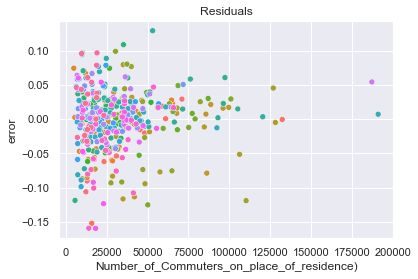

In [51]:
g = sns.scatterplot(data=df_mixed, x="Number_of_Commuters_on_place_of_residence)", y="error",  hue="ags5")
g.set_title('Residuals')
g.legend_.remove()
plt.savefig('Commuters_Residuals.png')

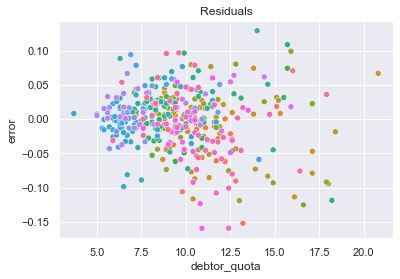

In [52]:
g = sns.scatterplot(data=df_mixed, x="debtor_quota", y="error",  hue="ags5")
g.set_title('Residuals')
g.legend_.remove()
plt.savefig('debtor_quota_Residuals.png')

<AxesSubplot:xlabel='debtor_quota', ylabel='Density'>

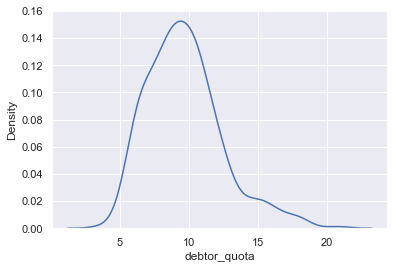

In [53]:
sns.kdeplot(data=df_mixed, x="debtor_quota", common_norm=False)

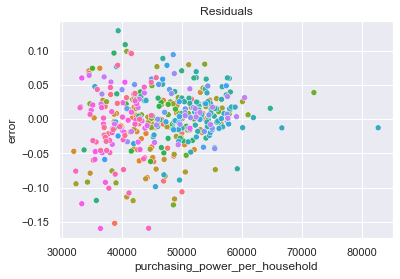

In [54]:
g = sns.scatterplot(data=df_mixed, x="purchasing_power_per_household", y="error",  hue="ags5")
g.set_title('Residuals')
g.legend_.remove()
plt.savefig('purchasing_power_Residuals.png')

<AxesSubplot:xlabel='purchasing_power_per_household', ylabel='Density'>

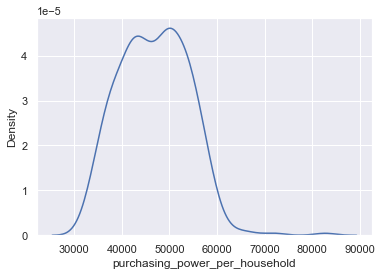

In [55]:
sns.kdeplot(data=df_mixed, x="purchasing_power_per_household", common_norm=False)

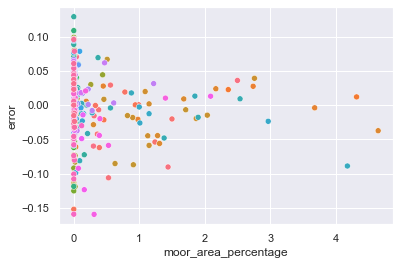

In [56]:
g = sns.scatterplot(data=df_mixed, x="moor_area_percentage", y="error",  hue="ags5")
g.legend_.remove()

In [57]:
df['diff_pred'] = df.groupby('ags5')['pred'].diff(1) 

In [58]:
df['diff_sign'] =  np.where(abs(df['diff_pred']) + abs(df['diff_ground_truth']) == abs(df['diff_pred'] + df['diff_ground_truth']), 'same', 'different')

In [59]:
df['diff_sign'].value_counts(normalize=True) * 100

same         83.364505
different    16.635495
Name: diff_sign, dtype: float64